In [66]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
df = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv') 
df["datetime"] = pd.to_datetime(df["date"])
df

/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv
/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv


,date,meantemp,humidity,wind_speed,meanpressure,datetime
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013-01-01
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013-01-02
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013-01-03
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013-01-04
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013-01-05
...,...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217,2016-12-28
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762,2016-12-29
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762,2016-12-30
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000,2016-12-31


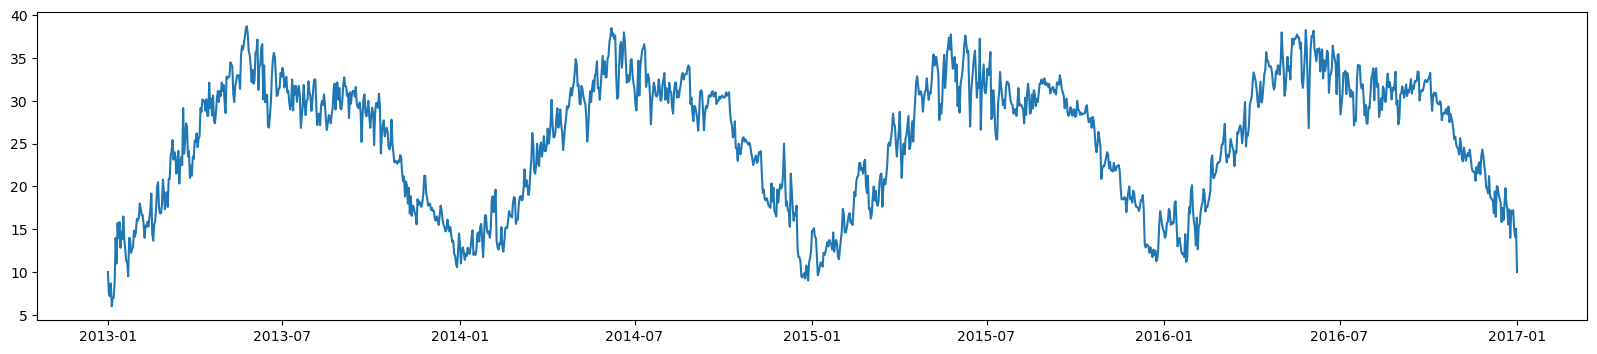

In [67]:
from matplotlib import pyplot as plt

plt.plot(df['datetime'], df['meantemp'])
plt.show()

P-value:  0.2774121372301602


/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


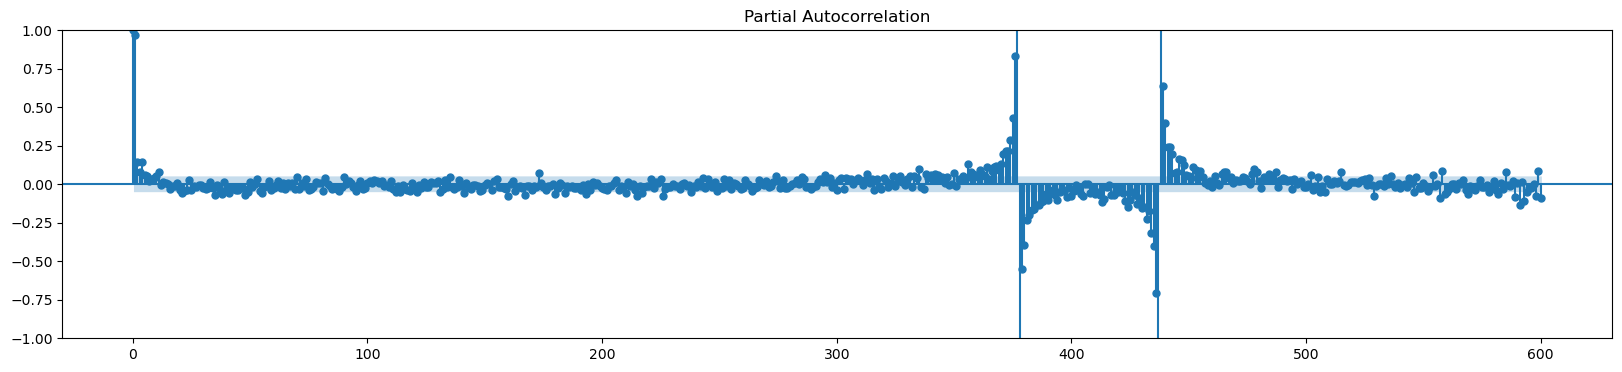

In [70]:
from statsmodels.tsa.stattools import adfuller

# stationarity test
df_stationarityTest = adfuller(df['meantemp'], autolag='AIC')
print("P-value: ", df_stationarityTest[1])

from statsmodels.graphics.tsaplots import plot_pacf
# plot partial autocorrelation
pacf = plot_pacf(df['meantemp'], lags=600)

The p-value for the stationary test is unfortunately > 0.05. Therefore, the process is not stationary. But we will still try to fit an AR model.

We see that we have a high auto-correlation for 2 and then again for around 380 and 430 lags. Therefore, we will choose an AR model of order around 430. If we take a look at the data, one period takes about 365 days (1 year). Which makes completely sense.

In [85]:
from statsmodels.tsa.ar_model import AutoReg

size_test = 200
train_data = df['meantemp'][:len(df)-size_test]
test_data = df['meantemp'][len(df)-size_test:]

# Instantiate and fit the AR model with training data
ar_model_365 = AutoReg(train_data, lags=365).fit()
ar_model_430 = AutoReg(train_data, lags=430).fit()

#print(ar_model_365.summary())

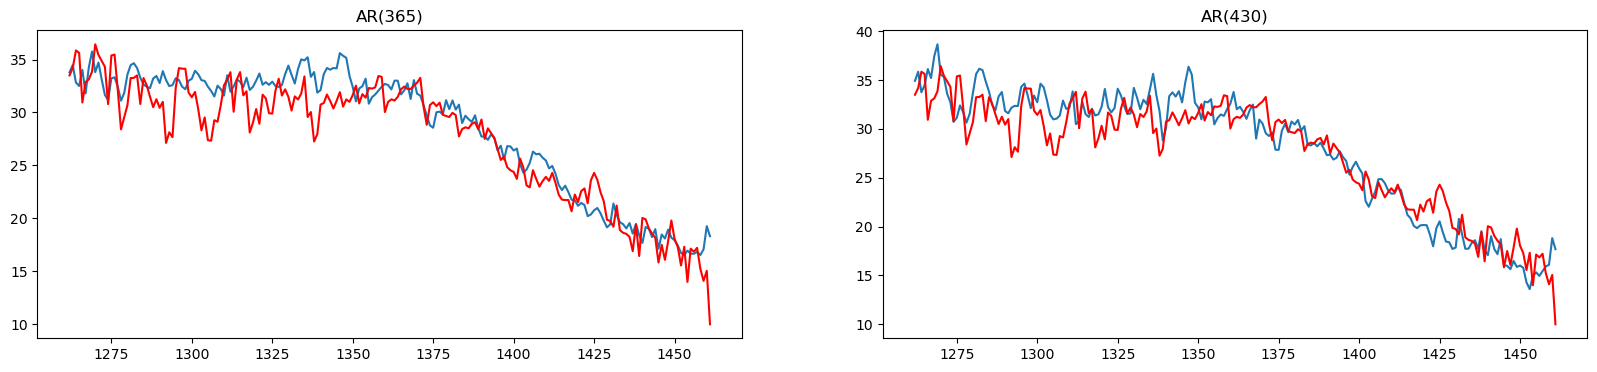

In [86]:
pred_365 = ar_model_365.predict(start=len(train_data), end=(len(df)-1), dynamic=False)
pred_430 = ar_model_430.predict(start=len(train_data), end=(len(df)-1), dynamic=False)


fig, axs = plt.subplots(1,2)
axs[0].plot(pred_365)
axs[0].set(title='AR(365)')
axs[0].plot(test_data, color='red')

axs[1].plot(pred_430)
axs[1].set(title='AR(430)')
axs[1].plot(test_data, color='red')

In [88]:
from sklearn.metrics import r2_score

print(f'R^2 for AR(365): {r2_score(test_data, pred_365)}')
print(f'R^2 for AR(430): {r2_score(test_data, pred_430)}')

R^2 for AR(365): 0.8472243151514339
R^2 for AR(430): 0.8359917254786593


We can see that the R^2 ist quite high for both models. But for the AR model with 365 lags, the score is higher. Therefore, we choose the AR model of order 365.